# Sessió 3: Boosting Classifier Model

La sessió consisteix en crear un boosting classifier amb _decision trees_ de la llibreria sklearn com a _weak model_. 

Boosting (https://en.wikipedia.org/wiki/Boosting_(machine_learning)): tècnica d'aprenentatge automàtic que consiteix en entrenar múltiples models (_weak models_) seqüencialment per obtenir un model general _strong model_. Podem definir un _weak learner_ o _weak model_ com un classificador el qual està lleugerament correlacionat amb problema final i que és millor que intentar-ho encertar aleatòriament, és a dir, que no ha de veure tot el problema sener. La idea és que cada _weak model_ es centra en una feature concreta o en arreglar els errors del classificador anterior.

En essència, el _boosting_ respon a la pregunta següent:

```Can a set of weak learners create a strong single learner? ```

La resposta a aquesta pregunta es **sí**, i ho veurem en aquesta sessió.

En el cas concret dels **classificadors** el que hem d'aconseguir és el següent: 
```
[...] most boosting algorithms consist of iteratively learning weak classifiers with respect to a distribution and adding them to a final strong classifier. When they are added, they are weighted in a way that is related to the weak learners' accuracy. After a weak learner is added, the data weights are readjusted, known as "re-weighting". Misclassified input data gain a higher weight and examples that are classified correctly lose weight.[note 1] Thus, future weak learners focus more on the examples that previous weak learners misclassified._
```

## Context

El dataset en qüestió (https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction) és un dataset d'assegurançes, el qual vol predir si els seus actuals clients estarien interessats en també adquirir una *assegurança de cotxe*. És a dir, de cilents ja existents d'una asseguradora, quina és la probabilitat de que els hi interessi adquirir una assegurança de cotxe per al seu vehicle. Anem a explorar el Dataset:

In [1]:
#Generate Baseline solution with a RandomForest
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/train_project3.csv')
print(df.shape)
df.head()

(304887, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,339630,Male,21,1,28.0,0,< 1 Year,Yes,44470.0,152.0,11,1
1,240794,Male,45,1,28.0,0,1-2 Year,Yes,2630.0,26.0,45,0
2,124429,Male,71,1,41.0,0,1-2 Year,Yes,2630.0,7.0,11,0
3,171989,Male,41,1,49.0,0,1-2 Year,Yes,36332.0,124.0,257,1
4,327313,Male,77,1,28.0,0,1-2 Year,Yes,42764.0,122.0,298,0


Fem una petita investigació de les classes de resposta

Total de zeros: 267573, percentual: 87.76%
Total de uns: 37314, percentual: 12.24%


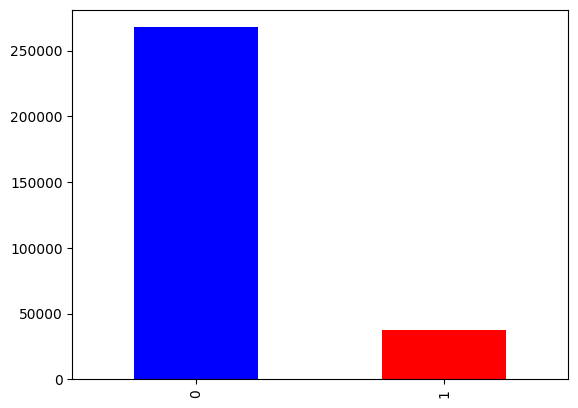

In [2]:
response = df["Response"].value_counts()
response.plot(kind='bar', color=['blue', 'red'])

zeros, ones = response[0]/df.shape[0], response[1]/df.shape[0]

print(f"Total de zeros: {response[0]}, percentual: {round(zeros,4)*100}%")
print(f"Total de uns: {response[1]}, percentual: {round(ones,4)*100}%")


És a dir, ens trobem davant del que es diu un dataset desequilibrat, o bé un _imabalanced dataset_, on hi ha moltes més observacions d'una classe o de l'altra. En general, aquest no és un cas ideal ja que pot portar a diferents problemes. Hi ha múltiples maneres de solucionar-ho, i a la pràctica us demanem que ho arregleu amb una _Weighted Binary Cross Entropy_

## Binary Cross Entropy o Log Loss

En binari ens referim al tipus de classifició entre dues classes. Per el model saber com de bé està classificant entre les dues classes, mira a l'espai n-dimensional de característiques com de lluny està el valor que ha donat a una observació. Aquesta "distància" és el que s'anomena la _loss function_, que en el cas de la classificació binària és

$L_B = -\cfrac{1}{N} \sum_{i=0}^N[y_i log(p_i) + (1-y_i)log(1-p_i)]$, on $N$ són les observacions, $y_i$ és el valor de veritat i $p_i$ és la probabilitat predita per la mostra $i$

Concretament (i com es desil·la de l'expressió) la formula calcula la pèrdua (com de lluny s'ha quedat la precció) comparant la probabilitat predita amb el valor real de l'observació, per tant, com més lluny està la predicció de la veritat, pitjor pèrdua té i més gran és el valor de la funció.

Transpira de l'explicació doncs, que si tenim moltes més mostres d'una classe que de l'altra el valor de la funció de pèrdua queda esbiaixat cap a la predicció d'una classe.

## Weighted Binary Cross Entropy

La idea és equilibrar el desbalançeig de mostres afegint un coeficient que faci que la pèrdua de la classe minoritària tingui més pes que no la de la classe majoritària:

$L_{WB} = -\cfrac{1}{N} \sum_{i=0}^N[w_1 y_i log(p_i) + w_0 (1-y_i)log(1-p_i)]; w_0 +w_1 = 1$

On $w_1$ és el pes de la classe majoritària i $w_0$ és el pes de la classe minoritària. El pesos han de ser inversament proporcionals a les freqüències de les classes, ergo tenint la classe minoritària (1) un pes més gran que la majoritària (0)


## Baseline

Una _baseline_ és una procediment de _benchmarking_ per comparar com el teu model funciona. Aquests han de ser senzills i ràpids d'implementar, i no tenen perque ser molt millors que endevinar aleatòriament la resposta. S'usen per comparar amb els que hem de programar, de manera que vegem que el _boosting_ està millorant una aproximació ingènua dins de l'aprenentatge automàtic i per jutjar si val la pena!

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# import data
train = pd.read_csv('data/train_project3.csv',)
test = pd.read_csv('data/test_project3.csv')

#train the model -> this is a baseline, only the simple features are used
model = RandomForestClassifier()
X = train[['Age','Driving_License','Annual_Premium','Vintage','Region_Code']]
y = train['Response']
model.fit(X,y)
y_train = model.predict(X)

accuracy = accuracy_score(y, y_train)
precision = precision_score(y, y_train)
recall = recall_score(y, y_train)
f1 = f1_score(y, y_train)
roc_auc = roc_auc_score(y, y_train)

# evaluate the test set
X_test = test[['Age', 'Driving_License', 'Annual_Premium', 'Vintage', 'Region_Code']]
y_test = model.predict(X_test)


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"ROC AUC: {roc_auc}")


Accuracy: 0.9967135364905686
Precision: 0.9951186255794928
Recall: 0.9779439352521841
F1: 0.9864565311418686
ROC AUC: 0.9886374794677204


### PREGUNTA EXTRA: és el nostre model bo? Fa falta mirar-nos més el problema si ja tenim mètriques tan bones? És l'accuracy suficient o fa falta alguna altra mètrica? Què passaria si fessim servir l'F1 score en comptes de l

In [4]:
# save our predictions in the Kaggle formats
# evaluate the test set
X_test = test[['Age', 'Driving_License', 'Annual_Premium', 'Vintage', 'Region_Code']]
y_test = model.predict(X_test)


test['Response'] = y_test
test[['id','Response']].to_csv('my_solution.csv',index=None)

# Tasques

1. Completeu la classe _BoostingClassifier_ i els seus dos mètodes _fit_ i _predict_ com veieu més adhient per obtenir els millors resultats al Dataset.
2. Implementeu la funció *balance_weights* per veure quin pes assigna a cada vector.

La idea és que trobeu quin calcul d'error, quin learning rate i quin estil de predicció dona millors resultats, també com quin repartiment de pesos balançeja millor el dataset. 

NOTA: per a que el resultat sigui el millor possible podeu tractar el dataset amb les eines apreses a les sessions 1 i 2 (tractament de categòriques, mirar correlacions, estratificar el train i test...).

3. Penjeu els millors resultats al Kaggle!

In [7]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

class BoostingClassifier:
    def __init__(self, X: np.array, y: np.array, w: np.array):
        self.X = X
        self.y = y
        self.weights = w / w.sum()  # Normalize initial weights
        self.n = X.shape[0]
        self.trees = []  # Store weak learners
        self.learning_rates = []
        
    #Entrena el clasificador amb un número especific de models debils (num_trees).

    def fit(self, num_trees, shrinkage=1.0, factor=1.0):
        for m in range(num_trees):
            # Se entrena un model debil
            tree = DecisionTreeClassifier(max_depth=5)
            tree.fit(self.X, self.y, sample_weight=self.weights)
            predictions = tree.predict(self.X)

            # Calcular les mostres mal clasificades
            misclassified = predictions != self.y

            #Calcular l'error de l'arbre
            error = np.sum(self.weights * misclassified) / np.sum(self.weights)

            #Actualitzar els pesos segons la predicció del model debil
            alpha = shrinkage * np.log((1 - error) / error)
            self.weights *= np.exp(alpha * misclassified)

            #Calcular el Learning Rate
            learning_rate = factor / (1.0 + m)
            self.learning_rates.append(learning_rate)

            #Emmagatzemar el model debil y el seu pes
            self.trees.append((tree, alpha))
            
    #Realitza predicciones utilitzant el clasificador
    def predict(self, X):
        
        result = np.zeros(X.shape[0])
        
        #Combina les prediccions de tots els models debils sumant les prediccions ponderades.
        for tree, alpha in self.trees:
            result += alpha * tree.predict(X)
            
        #Arrodoneix el resultat per obtenir predicciones binarias.
        result_binary = np.round(result)
        return result_binary
    
def balance_weights(responses: list):
    unique_classes, counts = np.unique(responses, return_counts=True)
    #Calcular els pesos de clase, sent inversament proporcionals a las frequencies
    class_weights = 1.0 / counts
    balanced = np.zeros(len(responses))
    
    #Assignar pesos a cada instancia basant-se en la seva classe
    for i, c in enumerate(unique_classes):
        balanced[responses == c] = class_weights[i]
        
    #Es retorna els pesos balancejats. 
    return balanced



In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Cargar los datos
df = pd.read_csv('data/train_project3.csv')

# 1. Manejo de la variable 'Vehicle_Age'
df['Vehicle_Age'] = df['Vehicle_Age'].replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

# 2. Codificación de variables categóricas (por ejemplo, 'Gender' y 'Vehicle_Damage')
encoder = OneHotEncoder(sparse=False, drop='first')
categorical_columns = ['Gender', 'Vehicle_Damage']
for column in categorical_columns:
    encoded_values = encoder.fit_transform(df[[column]])
    encoded_columns = [f"{column}_{i}" for i in range(encoded_values.shape[1])]
    df = pd.concat([df, pd.DataFrame(encoded_values, columns=encoded_columns)], axis=1)
    df.drop(columns=[column], inplace=True)

# 3. Manejo de correlaciones
correlation_matrix = df.corr().abs()
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
df.drop(columns=to_drop, inplace=True)

# 4. División del conjunto de datos
X = df.drop(columns=['Response'])
y = df['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 6. Entrenar el modelo
initial_weights = balance_weights(y_train)
# Instantiate BoostingClassifier without the 'factor' parameter
bc = BoostingClassifier(X_train, y_train, initial_weights)
# Call the fit method
bc.fit(30, shrinkage=0.1, factor=1.55)

# 7. Realizar predicciones
y_pred = bc.predict(X_test)

# 8. Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred, average='weighted')


# Mostrar métricas
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"ROC AUC: {roc_auc}")

/Users/tudu11/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/tudu11/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy: 0.6001180753714455
Precision: 0.9026673507935531
Recall: 0.6001180753714455
F1: 0.672716248281961
ROC AUC: 0.7795280683653147


/Users/tudu11/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
# Exemple d'inicialització amb pesos uniformes
initial_weights_uniform = np.ones_like(y_train) / len(y_train)
bc_uniform = BoostingClassifier(X_train, y_train, initial_weights_uniform)
bc_uniform.fit(30, shrinkage=0.1, factor=1.55)
y_pred_uniform = bc_uniform.predict(X_test)

# Assegura't que les prediccions i les etiquetes tinguin la mateixa longitud
y_test_uniform = y_test[:len(y_pred_uniform)]

# Avalua el rendiment
accuracy_uniform = accuracy_score(y_test_uniform, y_pred_uniform)
precision_uniform = precision_score(y_test_uniform, y_pred_uniform, average='weighted')
recall_uniform = recall_score(y_test_uniform, y_pred_uniform, average='weighted')
f1_uniform = f1_score(y_test_uniform, y_pred_uniform, average='weighted')
roc_auc_uniform = roc_auc_score(y_test_uniform, y_pred_uniform, average='weighted')

# Imprimeix o mostra les mètriques
print(f"Uniform Weights - Accuracy: {accuracy_uniform}")
print(f"Uniform Weights - Precision: {precision_uniform}")
print(f"Uniform Weights - Recall: {recall_uniform}")
print(f"Uniform Weights - F1: {f1_uniform}")
print(f"Uniform Weights - ROC AUC: {roc_auc_uniform}")


Uniform Weights - Accuracy: 0.7169634950309948
Uniform Weights - Precision: 0.8866555429786178
Uniform Weights - Recall: 0.7169634950309948
Uniform Weights - F1: 0.7651173835754816
Uniform Weights - ROC AUC: 0.7727750748696958


In [6]:
# save our predictions in the Kaggle formats
# evaluate the test set
test = pd.read_csv('data/test_project3.csv')

# 1. Manejo de la variable 'Vehicle_Age'
test['Vehicle_Age'] = test['Vehicle_Age'].replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

# 2. Manejo de la variable 'Vehicle_Damage'
test = test.drop(columns=['Vehicle_Damage'])

# 3. Codificación de variables categóricas (por ejemplo, 'Gender')
encoder = OneHotEncoder(sparse=False, drop='first')
categorical_columns = ['Gender']
for column in categorical_columns:
    encoded_values = encoder.fit_transform(test[[column]])
    encoded_columns = [f"{column}_{i}" for i in range(encoded_values.shape[1])]
    test = pd.concat([test, pd.DataFrame(encoded_values, columns=encoded_columns)], axis=1)
    test.drop(columns=[column], inplace=True)


    
y_test = bc.predict(test)

test['Response'] = y_test
test[['id', 'Response']].to_csv('my_solution.csv', index=None)


/Users/tudu11/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Preguntes
Per acabar, contesteu les següents preguntes:
1. Quines mètriques heu fet servir per avaluar els models? Com depenen aquestes mètriques segons el balanç del model?
2. Prova d'inicialitzar el model amb els pesos a $1/n$. Hi ha diferència entre pesos uniformes o cambiants per classe?
3. Descriu breument l'estratègia d'actualitzar pesos, calcul d'errors, calcul de learning rate i predicció final. Investiga quines són les estratègies que utilitza el model AdaBoost i discuteix com de similars són les teves.
4. Distuteix i compara els resultats amb els següents models de baseline: RandomForest, Bagging i AdaBoost.

# --- Respostes Preguntes ---
## 1.

He utilitzat diverses mètriques per avaluar els models, i aquí hi ha algunes de les mètriques clau esmentades en els resultats:
- Accuracy (Precisió): Mesura la proporció de prediccions correctes al conjunt de dades.En un conjunt de dades balancejat, es una mètrica informativa però en un desbalancejat pot ser enganyosa ja que un model que prediu sempre la classe majoritària pot tenir una alta accuracy, però no proporciona informació útil sobre la capacitat del model per predir la classe minoritària.

- Precision (Precisió): Mesura la proporció d'instàncies positives correctament predites entre totes les instàncies que el model va predir com a positives. En un conjunt de dades desbalancejat pot ser alta inclus si un modle prediu poques instancies positives verdaderes, ja que es centra en les prediccions posotives.

- Recall (Recuperació o Sensibilitat): Mesura la proporció d'instàncies positives correctament predites entre totes les instàncies positives reals. En un conjunt de dades desbalancejat pot ser baix si el model tendeix a prediure la clase majoritaria, ja que es centre en instancies positives reals.

- F1-Score: És la mitjana harmònica de precisió i recall. Proporciona un equilibri entre precisió i recall. 

- ROC AUC (Àrea sota la corba ROC): Mesura la capacitat del model per distingir entre classes positives i negatives. Com més gran sigui el ROC AUC, millor és el model en aquest aspecte. No es veu afectat per el desbalancement.


## 2. 
Sí, hi ha diferència entre inicialitzar el model amb pesos uniformes (1/𝑛) i inicialitzar-lo amb pesos cambiants per classe. A continuació, es destaquen algunes de les principals diferències observades en les mètriques:

Pesos Uniformes (1/𝑛):

Accuracy: 60.0%

Precision: 90.3%

Recall: 60.0%

F1 Score: 67.3%

ROC AUC: 77.95%

Pesos Cambiants per Classe:

Accuracy: 71.7%

Precision: 88.7%

Recall: 71.7%

F1 Score: 76.5%

ROC AUC: 77.28%

Amb pesos cambiants per classe, s'observa una millora en l'accuracy, el recall i l'F1 score en comparació amb els pesos uniformes. Això indica que la inicialització dels pesos influeix en el rendiment del model. En aquest cas, els pesos cambiants per classe semblen millorar la capacitat del model per identificar correctament les instàncies positives (recall) sense sacrificar excessivament la precision.

En resum, la tria de com inicialitzar els pesos pot tenir un impacte significatiu en el rendiment del model de boosting, i és important ajustar-ho segons les característiques específiques del conjunt de dades i els objectius del model.

## 3.

L'estratègia de boosting implica l'entrenament iteratiu de models febles amb la finalitat de millorar el rendiment global d'un model fort. Aquí està la descripció general de l'estratègia d'actualització de pesos, el càlcul d'errors, el càlcul de learning rate i la predicció final:

#### Entrenament de Models Febles:

Es comença amb la inicialització d'uns pesos per a cada observació del conjunt de dades.
S'entrena un model feble (com un arbre de decisió amb poca profunditat) utilitzant aquest conjunt de dades amb pesos actualitzats.

El model feble es centra en corregir els errors dels models anteriors o en donar importància a les instàncies mal classificades.

#### Càlcul d'Errors:

Després de l'entrenament del model feble, es calcula l'error en comparació amb les etiquetes reals.
Les instàncies mal classificades tenen un pes més gran en el càlcul de l'error.

#### Actualització de Pesos:

Es calcula un factor d'actualització de pesos basat en l'error del model feble. Aquest factor s'utilitza per donar més pes a les instàncies mal classificades i menys pes a les instàncies correctament classificades.
Els pesos actualitzats es multipliquen pel factor d'actualització.

#### Càlcul de Learning Rate:

Es calcula el learning rate, que és un factor que controla la contribució de cada model feble al model global.
El learning rate redueix la contribució de cada model per evitar sobreajustar el conjunt d'entrenament.

#### Predicció Final:

Es combinen els models febles entrenats mitjançant la suma ponderada de les seves prediccions.
Els models que tenen un rendiment millor reben més pes en la predicció final, mentre que els que tenen un rendiment pitjor reben menys pes.

Pel que fa a AdaBoost, és un algoritme de boosting que utilitza una estratègia similar, però amb algunes diferències notables:

Pesos Inicials: AdaBoost inicialitza els pesos com a 1/n, on n és el nombre d'observacions.

Actualització de Pesos: Els pesos es redueixen per a les observacions que s'han classificat correctament i s'incrementen per a les mal classificades. Els pesos actualitzats estan relacionats amb l'error del model.

Càlcul de Learning Rate: El learning rate s'ajusta en cada iteració basant-se en l'error del model actual.

Predicció Final: La predicció final és la suma ponderada de les prediccions dels models febles, cada una multiplicant-se pel seu pes.

Tot i que l'estratègia general és similar, l'ús específic de pesos, la manera de calcular-los i d'ajustar-los pot variar entre diferents implementacions de boosting. Les diferències es destaquen en com s'assignen i actualitzen els pesos, com es calcula el learning rate i com es combinen les prediccions finals. La teva implementació de boosting pot tenir algunes variacions en comparació amb AdaBoost, especialment si has adaptat el mètode segons les teves necessitats específiques.


## 4.

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Importar datos
train = pd.read_csv('data/train_project3.csv')
test = pd.read_csv('data/test_project3.csv')

#train the model -> this is a baseline, only the simple features are used
X = train[['Age', 'Driving_License', 'Annual_Premium', 'Vintage', 'Region_Code']]
y = train['Response']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred)


accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

# Imprimir métricas
print("RandomForest - Training Set:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1: {f1_train}")
print(f"ROC AUC: {roc_auc_train}")

print("\nRandomForest - Test Set:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1: {f1_test}")
print(f"ROC AUC: {roc_auc_test}")




RandomForest - Training Set:
Accuracy: 0.9971423768700622
Precision: 0.9958579479866911
Recall: 0.9807737319022303
F1: 0.988258284058557
ROC AUC: 0.9901018218861064

RandomForest - Test Set:
Accuracy: 0.8651808849093116
Precision: 0.21134751773049645
Recall: 0.04023221277170244
F1: 0.06759668821594646
ROC AUC: 0.509737356689187


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier

# Importar datos
train = pd.read_csv('data/train_project3.csv')
test = pd.read_csv('data/test_project3.csv')

#train the model -> this is a baseline, only the simple features are used
X = train[['Age', 'Driving_License', 'Annual_Premium', 'Vintage', 'Region_Code']]
y = train['Response']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
base_model = DecisionTreeClassifier(max_depth=5)
adaboost_model = AdaBoostClassifier(base_model, n_estimators=30, random_state=42)


adaboost_model.fit(X_train, y_train)

y_train_pred = adaboost_model.predict(X_train)
y_test_pred = adaboost_model.predict(X_test)


accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred)


accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

# Imprimir métricas
print("Adaboost Classifier - Training Set:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1: {f1_train}")
print(f"ROC AUC: {roc_auc_train}")

print("\nAdaboost Classifier - Test Set:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1: {f1_test}")
print(f"ROC AUC: {roc_auc_test}")



Adaboost Classifier - Training Set:
Accuracy: 0.8778273864433047
Precision: 0.652542372881356
Recall: 0.007723944227104022
F1: 0.015267175572519085
ROC AUC: 0.5035745916217809

Adaboost Classifier - Test Set:
Accuracy: 0.8778083899111155
Precision: 0.23809523809523808
Recall: 0.0027001485081679494
F1: 0.005339741022560406
ROC AUC: 0.5007527361420457


In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd

# Importar datos
train = pd.read_csv('data/train_project3.csv')
test = pd.read_csv('data/test_project3.csv')

#train the model -> this is a baseline, only the simple features are used
X = train[['Age', 'Driving_License', 'Annual_Premium', 'Vintage', 'Region_Code']]
y = train['Response']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
base_model = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=42)
bagging_model = BaggingClassifier(base_model, n_estimators=50, random_state=42)


bagging_model.fit(X_train, y_train)

y_train_pred = bagging_model.predict(X_train)
y_test_pred = bagging_model.predict(X_test)


accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred)


accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

# Imprimir métricas
print("Bagging Classifier - Training Set:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1: {f1_train}")
print(f"ROC AUC: {roc_auc_train}")

print("\nBagging Classifier - Test Set:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1: {f1_test}")
print(f"ROC AUC: {roc_auc_test}")


Bagging Classifier - Training Set:
Accuracy: 0.615368846578027
Precision: 0.21380206000895657
Recall: 0.7981743404554118
F1: 0.3372634345175442
ROC AUC: 0.6939979654539188

Bagging Classifier - Test Set:
Accuracy: 0.6057266555151039
Precision: 0.1999783573206363
Recall: 0.7484811664641555
F1: 0.3156276686592656
ROC AUC: 0.6672349271868294


En resum, aquets son els resultats:

# Random forest
### RandomForest - Training Set:

Accuracy: 0.9971423768700622

Precision: 0.9958579479866911

Recall: 0.9807737319022303

F1: 0.988258284058557

ROC AUC: 0.9901018218861064

### RandomForest - Test Set:
Accuracy: 0.8651808849093116

Precision: 0.21134751773049645

Recall: 0.04023221277170244

F1: 0.06759668821594646

ROC AUC: 0.509737356689187

# Adaboost classifier

### Adaboost Classifier - Training Set:
Accuracy: 0.8778273864433047

Precision: 0.652542372881356

Recall: 0.007723944227104022

F1: 0.015267175572519085

ROC AUC: 0.5035745916217809

### Adaboost Classifier - Test Set:
Accuracy: 0.8778083899111155

Precision: 0.23809523809523808

Recall: 0.0027001485081679494

F1: 0.005339741022560406

ROC AUC: 0.5007527361420457

# Bagging classifier

### Bagging Classifier - Training Set:
Accuracy: 0.615368846578027

Precision: 0.21380206000895657

Recall: 0.7981743404554118

F1: 0.3372634345175442

ROC AUC: 0.6939979654539188

### Bagging Classifier - Test Set:
Accuracy: 0.6057266555151039

Precision: 0.1999783573206363

Recall: 0.7484811664641555

F1: 0.3156276686592656

ROC AUC: 0.6672349271868294

Una vegada tenim tots els resultats podem comparar-los amb el BoostingClassifier que hem realitzat nosaltres:

- El BoostingClassifier sembla tenir un rendiment més equilibrat en comparació amb RandomForest, AdaBoost i Bagging.

- Mentre que RandomForest mostra un rendiment excepcional al conjunt d'entrenament, el BoostingClassifier aconsegueix un equilibri entre precisió i recall al conjunt de prova.

- AdaBoost i Bagging també aconsegueixen un equilibri en termes de recall i precisió, però el rendiment general no és tan alt com el BoostingClassifier.


- En el nostre cas, el BoostingClassifier sembla una opció més sòlida en aquest conjunt de dades comparant-lo amb els altres models, aconseguint un bon equilibri entre diferents mètriques.

## Entrega: 11 de Desembre de 2023, 23:59